## Vorbereitung/ Data Wrangling
Drop all countries that have less than MIN_NUMBER_OF_ENTRIES elements --> Danach kann man einen inner Join auf alle Spalten aller Datensätze durchführen. Die Analyse wird nur gemacht wenn auch was da ist (inner join machen).

## Theses
- Re-Plot Gapminder World
- Why are some countries doing so bad?
- Population (density) of a country doesn't matter
- Income distribution/wealth matters
- Life expectacy vs Median income would be a better measure, instead oft average income.
- Which other factors do affect life? Wirkung hours?

## Used Data
- **GDP per capita** based on purchasing power parity (PPP). PPP GDP is gross domestic product converted to international dollars using purchasing power parity rates. An international dollar has the same purchasing power over GDP as the U.S. dollar 
- **Under-five mortality** rate (per 1,000 live births): The probability that a child born in a specific year will die before reaching the age of five if subject to current age-specific mortality rates. Expressed as a rate per 1,000 live births.

In [1]:
import os
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns
#import matplotlib.ticker as mticker
import sqlite3
from IPython.display import display, HTML

In [2]:
print(sys.version)

3.5.2 (default, Nov 23 2017, 16:37:01) 
[GCC 5.4.0 20160609]


In [3]:
from pathlib import Path

DATA_EXTENSIONS = '.xlsx'

def excel_contents(p_name):
    ret = []
    for root, dirs, files in os.walk(p_name):
        #print('Found directory: %s' % root)
        for filename in files:
            if filename.endswith('.xlsx'):
                #print(filename)
                ret.append(root + '/' + filename)
    return ret


In [4]:
# Path to the data
data_path = os.path.abspath(os.path.join('Gapminder/data'))
print("data_path = %s" % (data_path))

data_path = /home/joerg/unisoned/arbeit/DataAnalyst/P1/investigate_a_dataset/Gapminder/data


In [5]:
# os.scandir(data_path)
##pathname = Path(data_path).parent
# pathname
list_of_excel_files = excel_contents(data_path)

Excel files are ugly. Put all files found into a SQLite database.
Let the country be the column and the year be the row.

In [6]:
import warnings
warnings.filterwarnings('ignore') # Switch of UserWarning: The spaces in these column names will not be changed. In pandas versions < 0.14, spaces were converted to underscores.

MIN_NUMBER_OF_ENTRIES = 1 # Drop all countries that have less than MIN_NUMBER_OF_ENTRIES elements
#df.drop('reports', axis=1)
connlite3 = None
connlite3 = sqlite3.connect(data_path + "/gapminder_extract.sqlite3")
for xls_file in list_of_excel_files:
    #print("Loading:" + xls_file)
    pdf = pd.read_excel(xls_file)
    table_name = pdf.columns[0]
    print(table_name)
    pdf = pdf.rename(columns = {table_name:'Country'}) # .set_index("Country")
    pdf.drop_duplicates(subset=['Country'], keep=False, inplace=True) # Some datasets are corrupt and have duplicate countries or named "nan"
    pdfT = pdf.T.rename(columns=pdf["Country"]).drop('Country') # Make the countries the new column names and then drop the row that contains the countries
    pdfT.dropna(axis=1, thresh=MIN_NUMBER_OF_ENTRIES, inplace=True)
    #pdfT
    #pdfT = pdf.T.drop('Country') df.drop('reports', axis=1)
    pdfT.to_sql(table_name, connlite3, if_exists="replace") # Transpose to make the time the new index and the country the cloumn
connlite3.close()
warnings.filterwarnings('once')

CO2 per capita
Life expectancy
GDP (constant 2000 US$)
Under five mortality
GDP per capita
ODA % GNI
Cross sectors aid (% of total aid)
Annual number of AIDS deaths
average alcohol consumption, adult (15+) per capita consumption in litres pure alcohol
Estimated new HIV infections (All ages)
Physicians per 1000 people
Lung Female Mortality
Prevalence of current tobacco use among adults (>=15 years) (%) both sexes
Liver Male Mortality
Per capita government expenditure on health (PPP int. $)
Lung Male Mortality
Maternal Deaths
Children month 1-59, all cause death
TB mortality, all forms (per year)
Liver Female Mortality
War, age-adjusted mortality due to
Military expenditure (% of GDP)
Adult (15+) literacy rate (%). Total
Male 25-54 labour to population (%)
Other social services aid (% of total aid)
Health aid (% of total aid)
Economical infrastructure aid (% of total)
Production sector aid (% of total aid)
Total allocable aid (2007 US$)
Aid received % of GNI
ODA received, total (constant

In [6]:
def read_these_tables_from_sql(t_names, conn):
    tables = {}
    for table_name in t_names:
        querystr = "SELECT * FROM `" + table_name + "`"
        tables.update( {table_name: pd.read_sql_query(querystr, conn)} )#.set_index('index')} )
    return tables

def melt_tables(dict_of_tables):
    result = pd.DataFrame()
    for key, table in dict_of_tables.items(): #iteritems in Python 2
        #id_vars = ["index"] # can be more
        table['index'] = table['index'].astype('int64') # Because some index were stored as str. TODO correct this in read_these_tables_from_sql
        print(key)
        print(table.info())        
        df = pd.melt(table, id_vars=["index"], var_name="Country", value_name=key)
        #df = pd.melt(table, var_name="Country", value_name=key)
        if (not result.empty):
            result = pd.merge(result, df, how='outer', on=["index", "Country"], validate="one_to_one")
            # result = pd.merge(result, df, how='outer', on=["Country"])
            # From Pandas docs: Users can use the validate argument to automatically check whether there are unexpected duplicates in their merge keys. Key uniqueness is checked before merge operations and so should protect against memory overflows. Checking key uniqueness is also a good way to ensure user data structures are as expected.
        else:
            result = df
    return result
        


In [7]:
def divide_by_population(df_2_divide, list_of_indicators):
    for indicator in list_of_indicators:
        df_2_divide[indicator] = df_2_divide[indicator].div( df_2_divide["Total population"] / 100000 )
    return df_2_divide

def income_rebinning(income_dist):
    income_dist['20'] = income_dist['20']/2
    income_dist.insert(5,'30', income_dist['20'])
    income_dist['40'] = income_dist['40']/2
    income_dist.insert(7,'50',income_dist['40'])
    income_dist['60'] = income_dist['60']/2
    income_dist.insert(9,'70',income_dist['60'])
    income_dist.loc[:, ~income_dist.columns.isin(['index','Country'])].interpolate(axis=1)
    return income_dist

table_names =  [\
                "Life expectancy",\
                "Total population",\
                "GDP per capita"]#,\
#                "Total GDP, PPP",\
#                "GNI per capita, Atlas method (current US$)",\
#                "GNI per capita (constant 2000 US$)",\
#                "GNI per capita, PPP (current international $)",\
#                "Total GNI, PPP (current international $)",\
#                "GINI index"]
additional_table_names =  [\
                "Under five mortality",\
                "CO2 per capita",\
                #"Working hours per week",\
                "Per capita government expenditure on health (PPP int. $)",\
                "Military expenditure (% of GDP)",\
                "War, age-adjusted mortality due to",\
                "Arms exports (constant 1990 US$)",\
                "Arms imports (constant 1990 US$)",\
                "Physicians per 1000 people",\
                "Prevalence of current tobacco use among adults (>=15 years) (%) both sexes",\
                "Lung Female Mortality",\
                "Lung Male Mortality",\
                #"average alcohol consumption, adult (15+) per capita consumption in litres pure alcohol",\
                "Liver Female Mortality",\
                "Liver Male Mortality",\
                "TB mortality, all forms (per year)",\
                "Estimated new HIV infections (All ages)",\
                "Annual number of AIDS deaths",\
                "Maternal Deaths",\
                "Children month 1-59, all cause death"]#,\

additional_table_names_absolute = [\
                "Children month 1-59, all cause death",\
                "Maternal Deaths",\
                "TB mortality, all forms (per year)",\
                "Estimated new HIV infections (All ages)",\
                "Annual number of AIDS deaths",\
                ]

table_names_income =  [\
                "Income share held by highest 10%",\
                "Income share held by highest 20%",\
                "Income share held by second 20%",\
                "Income share held by third 20%",\
                "Income share held by fourth 20%",\
                "Income share held by lowest 20%",\
                "Income share held by lowest 10%"]

conn = sqlite3.connect(data_path + "/gapminder_extract.sqlite3")
querystr = "SELECT name FROM sqlite_master WHERE type='table'"
list_of_tables_in_db = pd.read_sql_query(querystr, conn)
# HTML(list_of_tables_in_db.to_html())

indicators = melt_tables(read_these_tables_from_sql(table_names, conn))#.dropna(how='all')
additional_indicators = melt_tables(read_these_tables_from_sql(additional_table_names, conn))
# The bins are always the value to the next
income_raw = read_these_tables_from_sql(table_names_income, conn)
income_dic = {}
income_dic.update( {'0': income_raw["Income share held by lowest 10%"]} )
income_dic.update( {'10': \
                   (income_raw["Income share held by lowest 20%"].set_index("index")\
                    - income_raw["Income share held by lowest 10%"].set_index("index")).reset_index()} )
income_dic.update( {'20': income_raw["Income share held by second 20%"]} )
income_dic.update( {'40': income_raw["Income share held by third 20%"]} )
income_dic.update( {'60': income_raw["Income share held by fourth 20%"]} )
income_dic.update( {'80': \
                   (income_raw["Income share held by highest 20%"].set_index("index")\
                    - income_raw["Income share held by highest 10%"].set_index("index")).reset_index()} )
income_dic.update( {'90': income_raw["Income share held by highest 10%"]} )
income_distribution = melt_tables(income_dic).dropna(how='any')
mysum = income_distribution[['0','10','20','40','60','80','90']].dropna().sum(axis=1)

income_distribution = income_distribution.groupby(['Country','index']).apply(income_rebinning)
conn.close()

GDP per capita
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 216 entries, 0 to 215
Columns: 204 entries, index to South Sudan
dtypes: float64(203), int64(1)
memory usage: 344.3 KB
None
Total population
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 81 entries, 0 to 80
Columns: 257 entries, index to Sint Maarten (Dutch part)
dtypes: float64(256), int64(1)
memory usage: 162.7 KB
None
Life expectancy
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 217 entries, 0 to 216
Columns: 211 entries, index to South Sudan
dtypes: float64(210), int64(1)
memory usage: 357.8 KB
None
Arms exports (constant 1990 US$)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52 entries, 0 to 51
Columns: 109 entries, index to Zimbabwe
dtypes: float64(108), int64(1)
memory usage: 44.4 KB
None
Liver Female Mortality
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48 entries, 0 to 47
Columns: 176 entries, index to Zimbabwe
dtypes: float64(175), int64(1)
memory usage: 66.1 KB
None
Lung Female Mortality
<cla

In [8]:
income_distribution[income_distribution['Country']=='United States']

,index,Country,60,10,40,30,90,50,0,70,20,80
4042,2000,United States,11.203006,3.557866,7.830236,5.34078,29.852664,7.830236,1.878162,11.203006,5.34078,15.963264


In [9]:
def get_income_dist_grouped_by_country_and_year(income_dist):
    data=income_dist.loc[:, ~income_dist.columns.isin(['index','Country'])].T
    data.reset_index(level=0, inplace=True)
    data.columns = ["pop","share"]
    data["pop"].astype(float)
    print(data.columns)
    return data

test_group = income_distribution.groupby(['Country','index']).get_group( ('Zambia',2004) )

#get_income_dist_grouped_by_country_and_year(test_group)
test_group

,index,Country,60,10,40,30,90,50,0,70,20,80
4226,2004,Zambia,10.31,2.31,6.405,3.88,38.9,6.405,1.32,10.31,3.88,16.28


In [10]:
def filter_most_recent(df):
    return df[df['index'] == df.groupby(['Country'])['index'].transform(max)]

# Only the most recent income distribution of each country is of interest.
most_recent_income_distribution = filter_most_recent(income_distribution)

In [11]:
most_recent_income_distribution

,index,Country,60,10,40,30,90,50,0,70,20,80
27,2005,Albania,11.275000,4.540000,8.290000,6.080000,25.870000,8.290000,3.240000,11.275000,6.080000,15.060000
47,1995,Algeria,11.405000,4.130000,8.155000,5.765000,26.940000,8.155000,2.800000,11.405000,5.765000,15.480000
82,2000,Angola,9.845000,1.400000,5.395000,2.830000,44.740000,5.395000,0.600000,9.845000,2.830000,17.120000
117,2005,Argentina,10.820000,2.210000,6.655000,3.890000,37.300000,6.655000,1.180000,10.820000,3.890000,16.580000
145,2003,Armenia,10.325000,4.920000,7.860000,6.140000,28.940000,7.860000,3.650000,10.325000,6.140000,13.840000
166,1994,Australia,11.785000,3.870000,8.600000,6.005000,25.400000,8.600000,2.030000,11.785000,6.005000,15.920000
202,2000,Austria,11.439108,5.215536,8.720928,6.665482,23.045386,8.720928,3.345601,11.439108,6.665482,14.742440
237,2005,Azerbaijan,10.835000,7.180000,9.330000,8.115000,17.490000,9.330000,6.110000,10.835000,8.115000,12.660000
267,2005,Bangladesh,10.560000,5.100000,8.065000,6.310000,26.620000,8.065000,4.260000,10.560000,6.310000,14.150000
297,2005,Belarus,11.560000,5.200000,8.910000,6.785000,22.040000,8.910000,3.600000,11.560000,6.785000,14.650000


# TODO: Divide data into countries with a GDP above and below, e.g 20000
What is a good value?

In [12]:
def interpolate_gapmind(country_group):
    #ig_df = country_group['Total population'].interpolate()
    ig_df = country_group.interpolate()
    #print(ig_df)
    return ig_df
#df.sort_values(['job','count'],ascending=False).groupby('job').head(3)
indicators_interp = indicators.sort_values(['Country','index'],ascending=True).reset_index(drop=True).groupby(['Country']).apply(interpolate_gapmind).reset_index(drop=True)#.get_group('Albania') #.apply(lambda group: group.interpolate(method='linear'))
additional_indicators_interp = additional_indicators.sort_values(['Country','index'],ascending=True).reset_index(drop=True).groupby(['Country']).apply(interpolate_gapmind).reset_index(drop=True)#.get_group('Albania') #.apply(lambda group: group.interpolate(method='linear'))


In [13]:
# TODO: Remove all rows that contain NaN only.
# ncome_dist.loc[:, ~income_dist.columns.isin(['index','Country'])]
additional_indicators_interp.head(5)

,index,Country,Arms exports (constant 1990 US$),Liver Female Mortality,Lung Female Mortality,Under five mortality,Liver Male Mortality,Arms imports (constant 1990 US$),Lung Male Mortality,Maternal Deaths,"Children month 1-59, all cause death",Military expenditure (% of GDP),Annual number of AIDS deaths,"TB mortality, all forms (per year)",Prevalence of current tobacco use among adults (>=15 years) (%) both sexes,Per capita government expenditure on health (PPP int. $),"War, age-adjusted mortality due to",Estimated new HIV infections (All ages),CO2 per capita,Physicians per 1000 people
0,1751,Afghanistan,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1755,Afghanistan,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1762,Afghanistan,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1763,Afghanistan,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1764,Afghanistan,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [14]:
len(indicators_interp['Country'].unique() )#.reset_index(drop=True)
#s = pd.Series([0, 1, np.nan, 5, np.nan])
#s.interpolate()

256

In [15]:
# TODO: Make function
indica = pd.merge(indicators_interp, most_recent_income_distribution, how='inner', on=["index", "Country"])
# Add a column holding the "Median GDP per capita"
indica['Median GDP per capita'] = 10 * indica['50']/100 * indica['GDP per capita']
indica['GDP per capita of the lowest 40 percent'] =  indica.loc[:, indica.columns.isin( (np.arange(5)*10).astype(str) )].mean(axis=1) / 100 * indica['GDP per capita'] #/ 0.4
x_name = 'GDP per capita'
sort_x_by = 'GDP per capita'
df = indica.sort_values(sort_x_by, ascending=True).reset_index(drop=True)
X = df[x_name]
# Stacked income distribution, sorted
# Y = df.loc[:, df.columns.isin( (np.arange(10)*10).astype(str) )].reindex(sorted(df.columns),axis=1).T # Select relative income distribution
# Select relative income distribution and sort index for stacked plot. "isin" is not required, but nice in case for ~isin
Y = df.loc[:, df.columns.isin( (np.arange(10)*10).astype(str) )].sort_index(axis=1).T

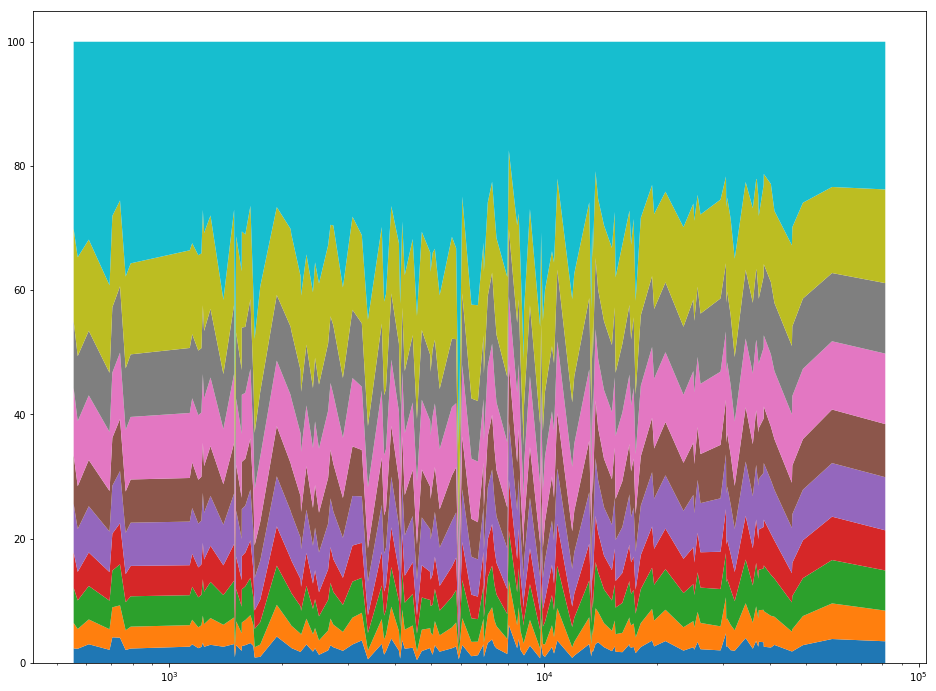

In [16]:
fig = plt.figure(figsize=(16,12))
fig = plt.figure(figsize=(16,12))
ax = fig.add_subplot(1, 1, 1)
ax.set_xscale('log')
ax.stackplot(X,Y)
plt.show()

In [17]:
# Which is the country that has the richest people, compared to the rest of the Nation?
df.iloc[df['90'].idxmax()]

index                                             1993
Country                                        Namibia
GDP per capita                                    5921
Total population                           1.55948e+06
Life expectancy                                     62
60                                                5.99
10                                                0.87
40                                                2.73
30                                               1.415
90                                                  65
50                                                2.73
0                                                 0.61
70                                                5.99
20                                               1.415
80                                               13.25
Median GDP per capita                          1616.43
GDP per capita of the lowest 40 percent        83.3677
Name: 60, dtype: object

In [28]:

for name_income,group_income in income_distribution.groupby(['Country','index']):
    my_ts = group_income

In [29]:
country = "Botswana"
year = 2004
#filt_country_year = (income_distribution['Country'] == country) & (income_distribution['index'] == year)
filt_country_year = (income_distribution['Country'] == country)
selected_income_dist = income_distribution[filt_country_year]

In [30]:
selected_income_dist

,index,Country,60,10,40,30,90,50,0,70,20,80
458,1986,Botswana,9.605,2.17,5.71,3.440,42.93,5.71,1.43,9.605,3.440,15.96
466,1994,Botswana,8.210,1.84,4.88,2.940,51.20,4.88,1.19,8.210,2.940,13.71
467,1995,Botswana,8.210,1.85,4.82,2.905,51.19,4.82,1.28,8.210,2.905,13.81


You will want to look into ways of reshaping your data so that it is tidy, especially if you want to do comparisons across indicators. After joining your data together, your columns might look like:
{Country, Year, Indicator 1 Value, Indicator 2 Value, ... }
- groupby funktioniert damit gut.
- Die Income distribution lieber als vector in einer Spalte darstellen. - Was ist hier eigentlich gemeint?

There is never more than one value per year - so the year can remain the index.

In [31]:
def bubble_plot(ax, b_df, x_name = 'GDP per capita'):
    X = b_df[x_name]
    Y = b_df.loc[ : , b_df.columns.isin( ['Life expectancy'] ) ]#.sort_index(axis=1).T # Select relative income distribution
    population = b_df.loc[ : , b_df.columns.isin( ['Total population'] ) ]
    countries = b_df.loc[ : , b_df.columns.isin( ['Country'] ) ]
    radius_max = 100
    radius_min = 2
    radius = (radius_max * population / population.max()).clip(lower=5)
        
    area = np.pi * ( radius )**2
    
    N = X.count()
    #x = np.random.rand(N)
    #y = np.random.rand(N)
    colors = np.random.rand(N)
    #area = np.pi * (15 * np.random.rand(N))**2  # 0 to 15 point radii
    
    # Major ticks every 20, minor ticks every 5
    major_ticks = np.arange(40, 95, 5)
    minor_ticks = np.arange(40, 95, 1)
    
    # ax.set_xscale('log')
    #ax.scatter(X, Y, s=area, c=colors, alpha=0.7)
    ax.plot(X,Y,'o')
    #ax.set_yticks(major_ticks)
    #ax.set_yticks(minor_ticks, minor=True)
    for pos in range(N):# zip(countries, Y):                                       # <--
        #print(xy)
        ax.annotate(countries['Country'].iloc[pos], xy=(X.iloc[pos],Y.iloc[pos]),\
                    textcoords='data', horizontalalignment='center', verticalalignment='center') # <--
    plt.show()
    
def secondary_plot_grouped_by_year(ax, b_df, list_of_indicators):
    # Compare all counties for each indicator in list_of_indicators with a horizontal bar plot
    # Data must have been grouped by year!
    # See https://matplotlib.org/gallery/api/barchart.html#sphx-glr-gallery-api-barchart-py
    N = b_df['Country'].count()
    number_of_indicators = len(list_of_indicators)
    ind = np.arange(N).astype(float)  # the x locations for the groups
    groupwidth = 0.8
    width = groupwidth/number_of_indicators       # the width of the bars
    
    x_name = 'Life expectancy'  # Plot countries with healthy population first
    dfp = b_df.sort_values(x_name, ascending=False).reset_index(drop=True)
    # Normalize all indicators to the same scale
    dfp[list_of_indicators] = dfp[list_of_indicators] / b_df[list_of_indicators].max() * 100
    
    rects = [] # List of rectangles
    colors = ['red','green','blue','black']
    
    for pos in range(len(list_of_indicators)):
        indicator = list_of_indicators[pos]
        Y = dfp.loc[ : , indicator ]#.sort_index(axis=1).T # Select relative income distribution
        #rect = ax.barh(ind + pos*width, Y, width, color=colors[pos])
        rect = ax.barh(ind + pos*width, Y, width)
        rects.append(rect)
    
    ax.set_xlabel('Scores')
    ax.set_title('Scores by country')
    ax.set_yticks(ind + (groupwidth-width)/2 )
    ax.set_yticklabels( dfp['Country'] + ": " + dfp['Life expectancy'].astype('str') )
    ax.invert_yaxis()  # labels read top-to-bottom

    ax.legend(rects, list_of_indicators)
    
    plt.show()

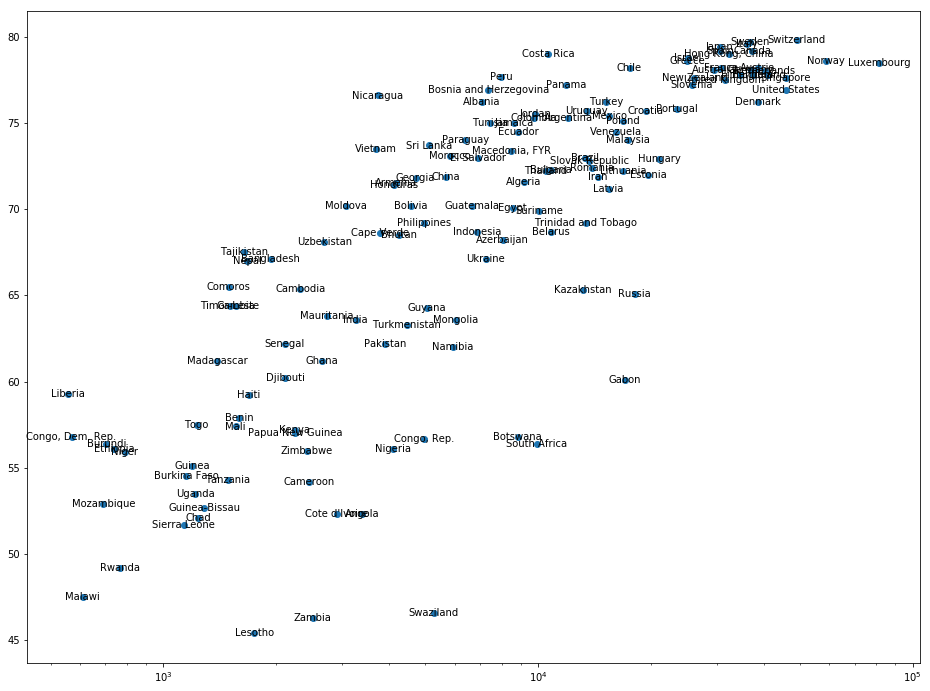

In [32]:
x_n = 'GDP per capita'
df = indica.sort_values(x_name, ascending=True).reset_index(drop=True)

fig = plt.figure(figsize=(16,12))
ax = fig.add_subplot(1, 1, 1)
ax.set_xscale('log')
bubble_plot(ax,df,x_name = x_n)

In 2013, Gallup published a list of countries with median annual household income, based on a self-reported survey of approximately 2000 adults from each country.[1] Using median, rather than mean income, results in a much more accurate picture of the typical income of the middle class since the data will not be skewed by gains and abnormalities in the extreme ends. The figures are in international dollars using purchasing power parity and are based on responses from 2006 to 2012 inflation adjusted to 2010 levels.

[1] http://news.gallup.com/poll/166211/worldwide-median-household-income-000.aspx

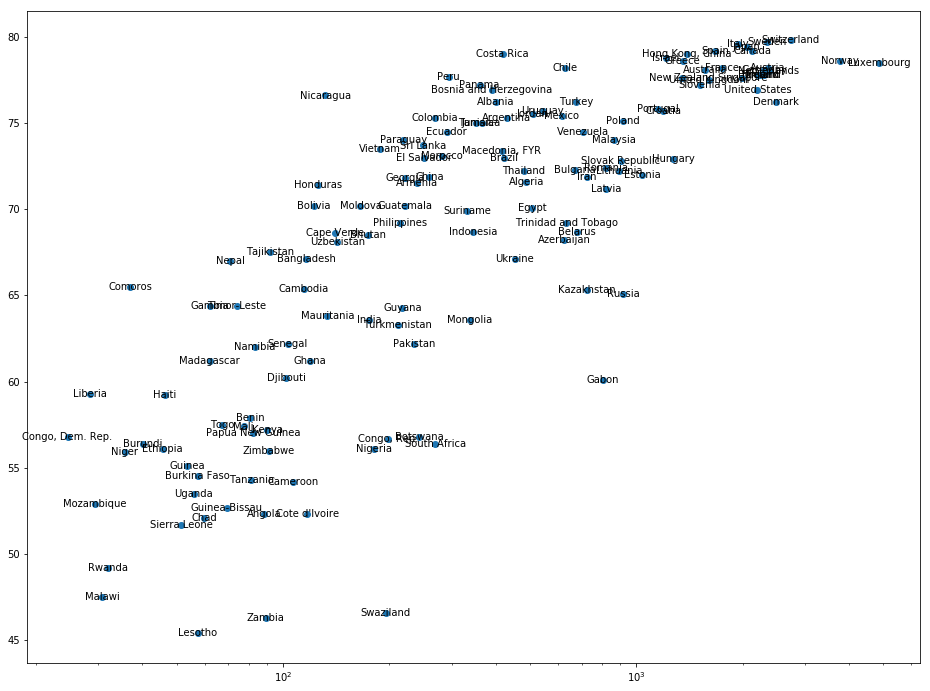

In [33]:
#x_n = 'Median GDP per capita'
x_n = 'GDP per capita of the lowest 40 percent'

fig = plt.figure(figsize=(16,12))
ax = fig.add_subplot(1, 1, 1)
ax.set_xscale('log')
bubble_plot(ax,df,x_name = x_n)

## Investigate secondary parameters

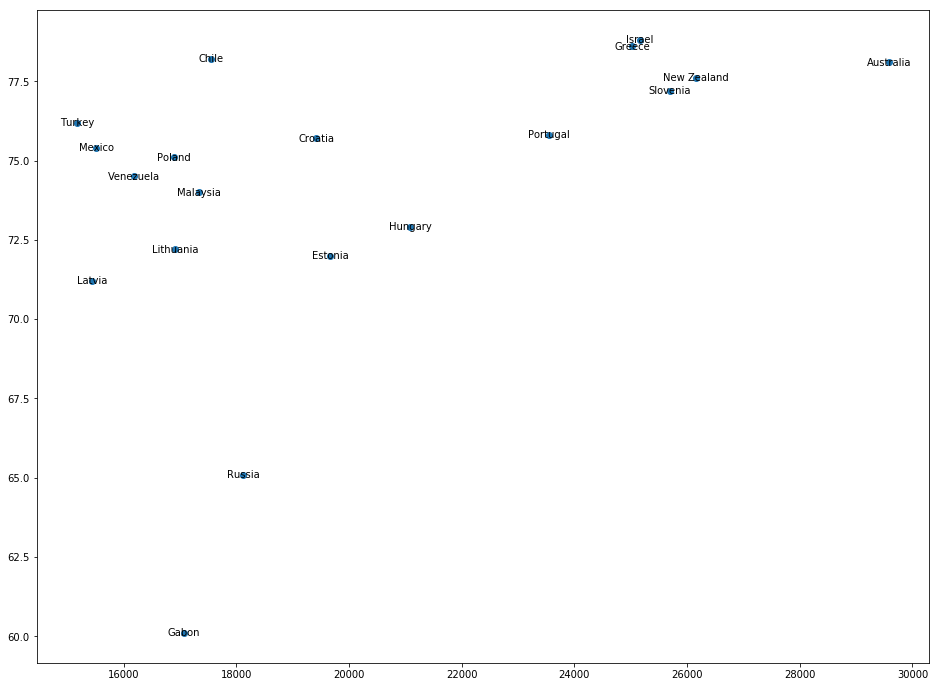

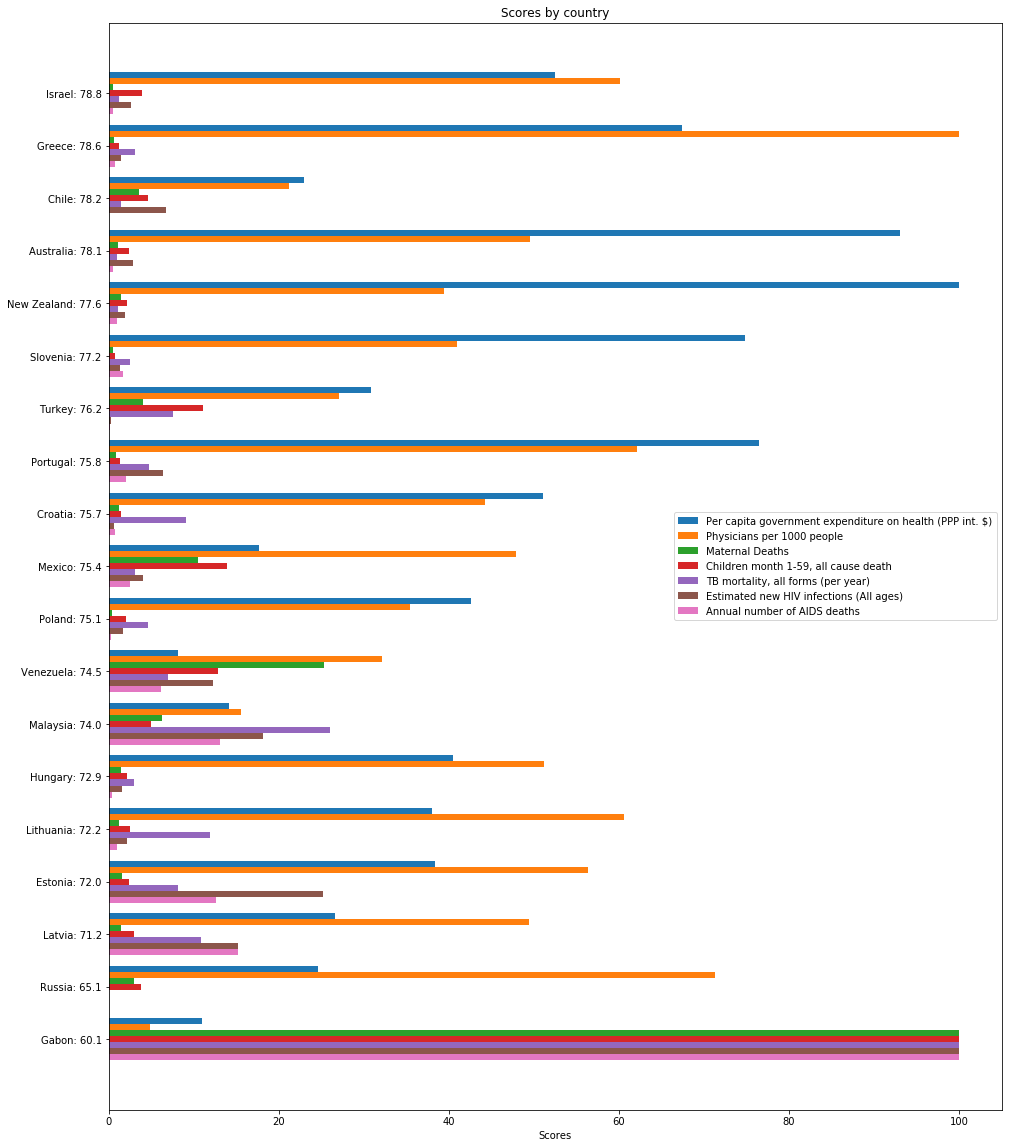

Per capita government expenditure on health (PPP int. $)    2513.316400
Physicians per 1000 people                                     6.043000
Maternal Deaths                                                9.435489
Children month 1-59, all cause death                         140.080724
TB mortality, all forms (per year)                            73.379074
Estimated new HIV infections (All ages)                      217.742058
Annual number of AIDS deaths                                 174.193647
dtype: float64

In [42]:
x_n = 'GDP per capita'


loi = ["Per capita government expenditure on health (PPP int. $)",\
       "Physicians per 1000 people",\
       "Maternal Deaths",\
       "Children month 1-59, all cause death",\
       "TB mortality, all forms (per year)",\
       "Estimated new HIV infections (All ages)",\
       "Annual number of AIDS deaths",\
       #"War, age-adjusted mortality due to",\
       #"Military expenditure (% of GDP)",\
       ] # List of indicators to compare

# Get most recent data from additional_indicators_interp
mr_additional_indicators = filter_most_recent(additional_indicators_interp)
mr_indicators = filter_most_recent(indicators_interp)

# Make the absolute values relative for comparision
mr_all_indicators_raw = pd.merge(indica, mr_additional_indicators, how='inner', on=["Country"])
mr_all_indicators = divide_by_population(mr_all_indicators_raw, additional_table_names_absolute)

# GDP greater than 15000
filter = (indica['GDP per capita'] > 15000) & (indica['GDP per capita'] < 30000)
#df = indica[filter].reset_index(drop=True)
# For a given year or most recent data:
#dff = pd.merge(mr_additional_indicators, df, how='inner', on=["Country"]).sort_values(x_name, ascending=True).reset_index(drop=True)
#df = indica[filter].reset_index(drop=True)


filter = (mr_all_indicators['GDP per capita'] > 15000) & (mr_all_indicators['GDP per capita'] < 30000)
dff = mr_all_indicators[filter].reset_index(drop=True).sort_values(x_name, ascending=True).reset_index(drop=True)

fig = plt.figure(figsize=(16,12))
ax = fig.add_subplot(1, 1, 1)
#ax.set_xscale('log')
bubble_plot(ax,dff,x_name = x_n)

fig = plt.figure(figsize=(16,20))
ax = fig.add_subplot(1, 1, 1)
#ax.set_xscale('log')
secondary_plot_grouped_by_year(ax,dff,loi)
dff[loi].max()

In [35]:
dff.columns

Index(['index_x', 'Country', 'Arms exports (constant 1990 US$)',
       'Liver Female Mortality', 'Lung Female Mortality',
       'Under five mortality', 'Liver Male Mortality',
       'Arms imports (constant 1990 US$)', 'Lung Male Mortality',
       'Maternal Deaths', 'Children month 1-59, all cause death',
       'Military expenditure (% of GDP)', 'Annual number of AIDS deaths',
       'TB mortality, all forms (per year)',
       'Prevalence of current tobacco use among adults (>=15 years) (%) both sexes',
       'Per capita government expenditure on health (PPP int. $)',
       'War, age-adjusted mortality due to',
       'Estimated new HIV infections (All ages)', 'CO2 per capita',
       'Physicians per 1000 people', 'index_y', 'GDP per capita',
       'Total population', 'Life expectancy', '60', '10', '40', '30', '90',
       '50', '0', '70', '20', '80', 'Median GDP per capita',
       'GDP per capita of the lowest 40 percent'],
      dtype='object')

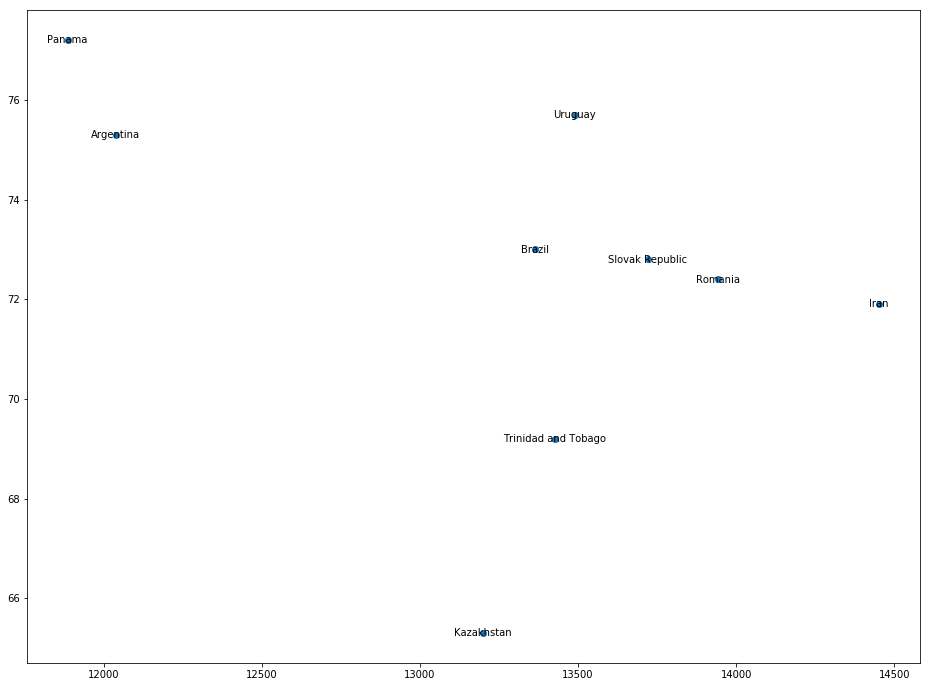

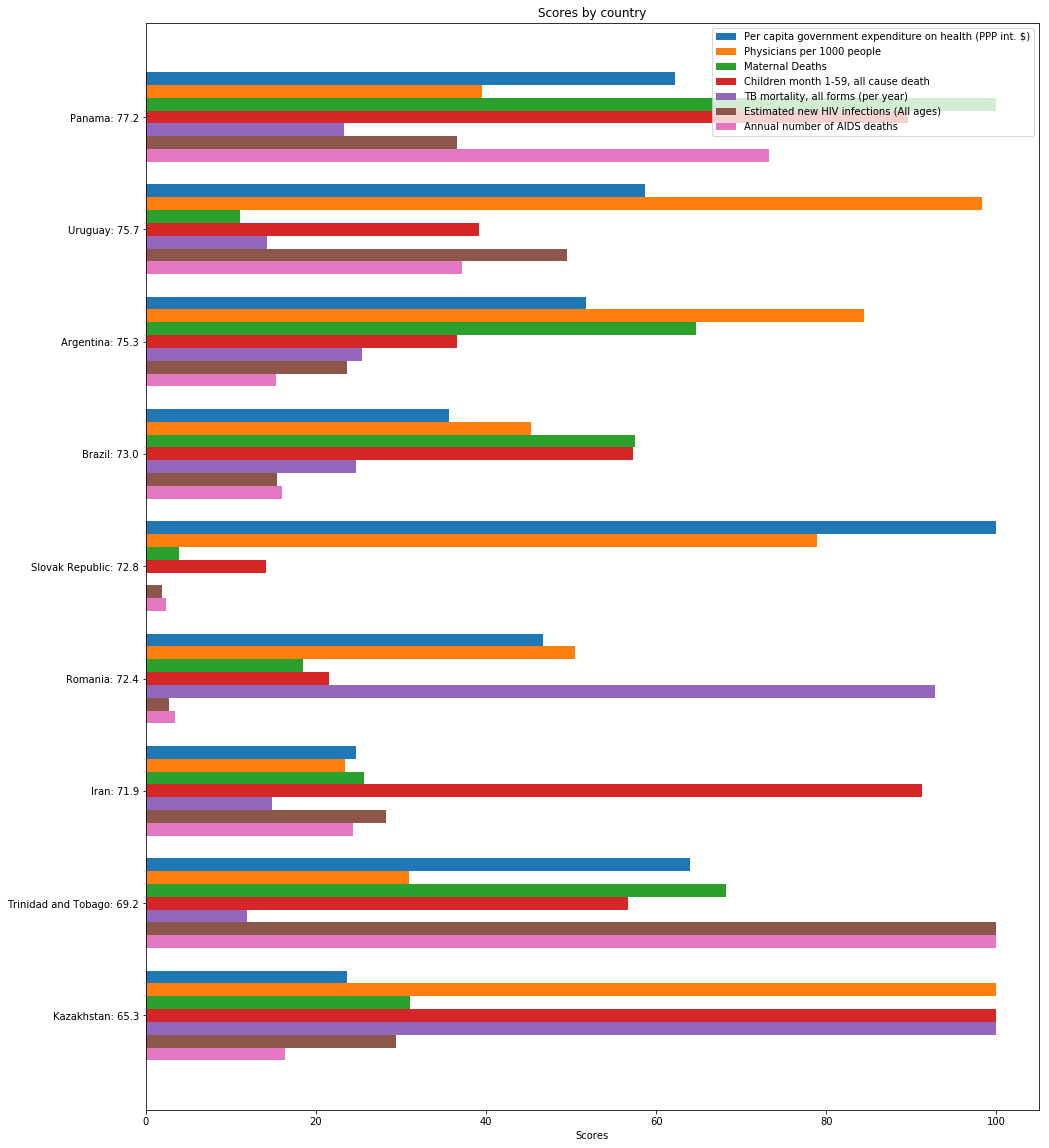

Per capita government expenditure on health (PPP int. $)    1356.765286
Physicians per 1000 people                                     3.800000
Maternal Deaths                                                1.894276
Children month 1-59, all cause death                          30.351421
TB mortality, all forms (per year)                            17.702244
Estimated new HIV infections (All ages)                       60.606746
Annual number of AIDS deaths                                  48.485397
dtype: float64

In [43]:
# GDP greater than 11000 and smaller than 15000

#filter = (indica['GDP per capita'] > 11000) & (indica['GDP per capita'] < 15000)
#df = indica[filter].reset_index(drop=True)
# For a given year or most recent data:
#dff = pd.merge(mr_additional_indicators, df, how='inner', on=["Country"]).sort_values(x_name, ascending=True).reset_index(drop=True)

filter = (mr_all_indicators['GDP per capita'] > 11000) & (mr_all_indicators['GDP per capita'] < 15000)
dff = mr_all_indicators[filter].reset_index(drop=True).sort_values(x_name, ascending=True).reset_index(drop=True)

fig = plt.figure(figsize=(16,12))
ax = fig.add_subplot(1, 1, 1)
#ax.set_xscale('log')
bubble_plot(ax,dff,x_name = x_n)

fig = plt.figure(figsize=(16,20))
ax = fig.add_subplot(1, 1, 1)
#ax.set_xscale('log')
secondary_plot_grouped_by_year(ax,dff,loi)
dff[loi].max()

These numbers might include data for non-natural death due "traditions" or to external force(e.g. war, smoking, alcohol, etc.)

TODO: Then make a general qualitative function / fit of income versus life expectancy
TODO: Plot GDP versus number of doctors
TODO: Then Plot GDP versus cost of health

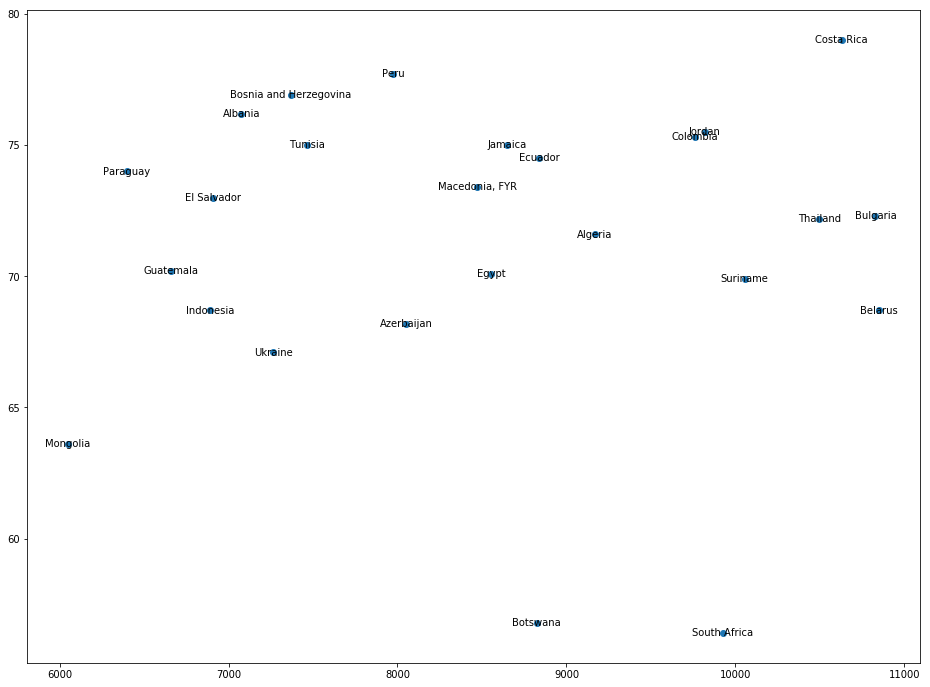

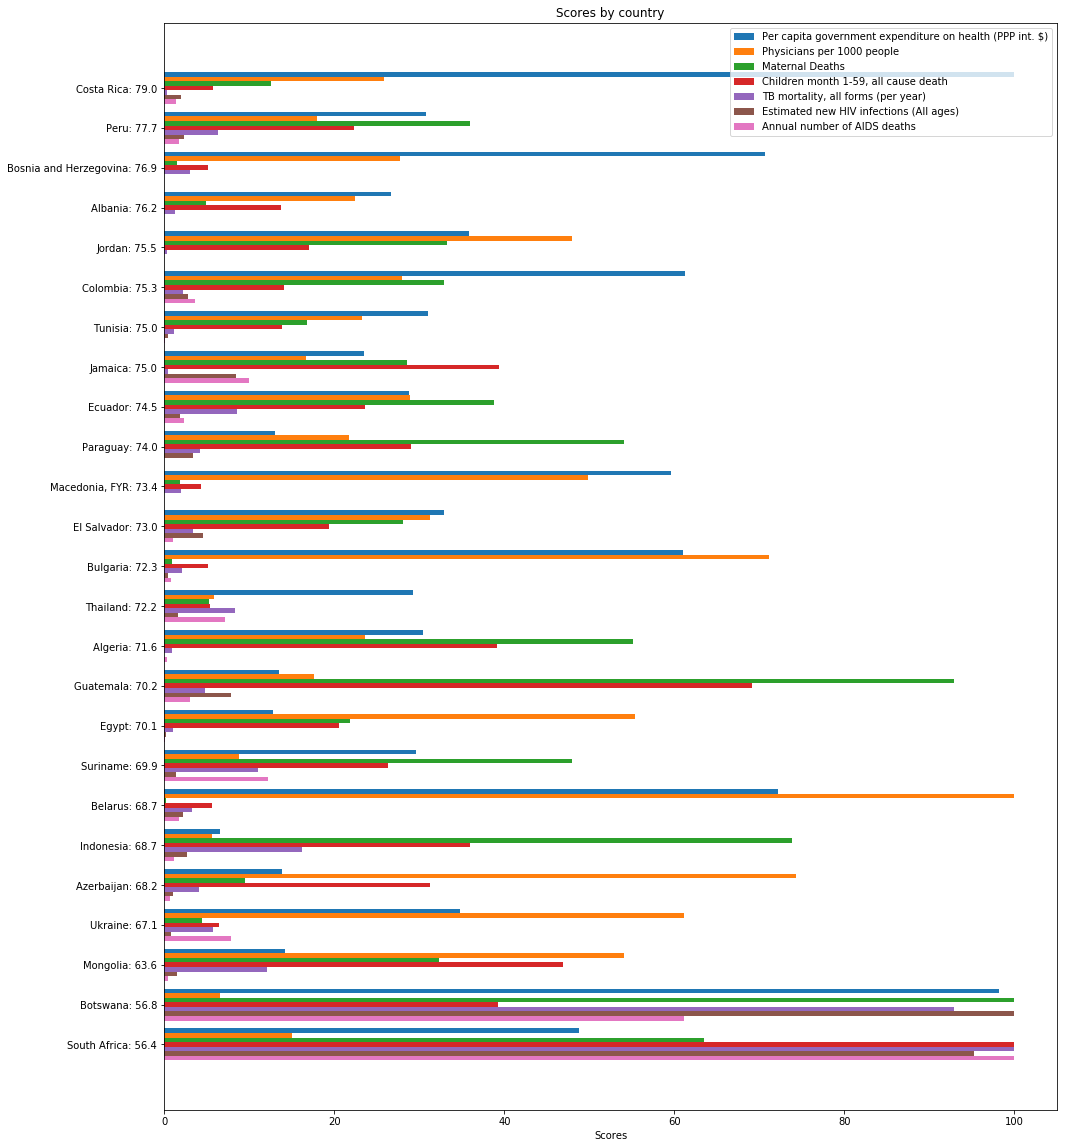

Per capita government expenditure on health (PPP int. $)    845.495646
Physicians per 1000 people                                    5.110000
Maternal Deaths                                               5.265525
Children month 1-59, all cause death                        114.121577
TB mortality, all forms (per year)                          249.291398
Estimated new HIV infections (All ages)                     888.160879
Annual number of AIDS deaths                                601.378413
dtype: float64

In [44]:
filter = (mr_all_indicators['GDP per capita'] > 6000) & (mr_all_indicators['GDP per capita'] < 11000)
dff = mr_all_indicators[filter].reset_index(drop=True).sort_values(x_name, ascending=True).reset_index(drop=True)


fig = plt.figure(figsize=(16,12))
ax = fig.add_subplot(1, 1, 1)
#ax.set_xscale('log')
bubble_plot(ax,dff,x_name = x_n)

fig = plt.figure(figsize=(16,20))
ax = fig.add_subplot(1, 1, 1)
#ax.set_xscale('log')
secondary_plot_grouped_by_year(ax,dff,loi)
dff[loi].max()

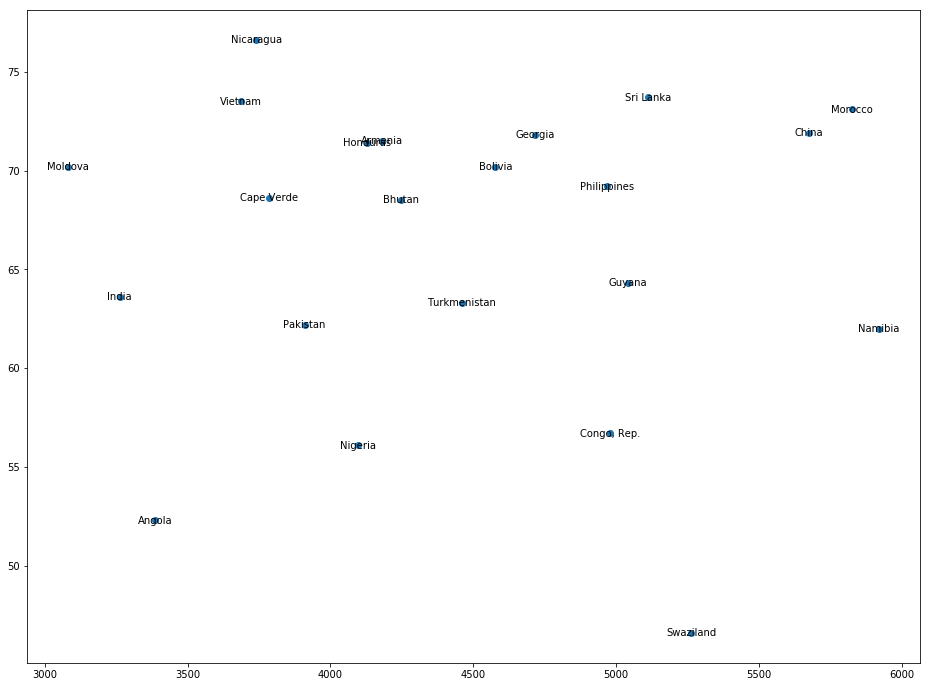

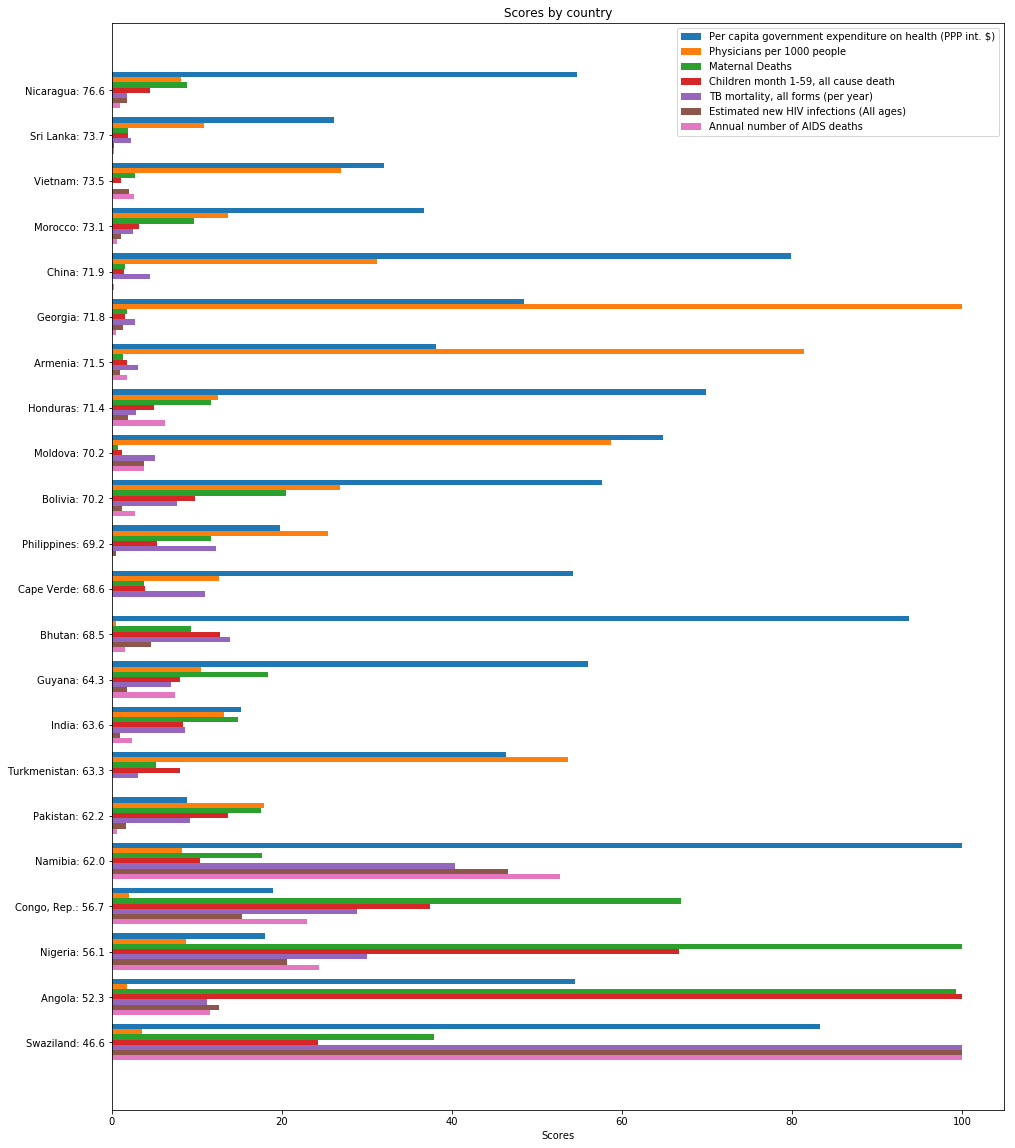

Per capita government expenditure on health (PPP int. $)     254.299584
Physicians per 1000 people                                     4.538000
Maternal Deaths                                               29.404560
Children month 1-59, all cause death                         856.950011
TB mortality, all forms (per year)                           336.724772
Estimated new HIV infections (All ages)                     1209.566742
Annual number of AIDS deaths                                 632.696450
dtype: float64

In [45]:
filter = (mr_all_indicators['GDP per capita'] > 3000) & (mr_all_indicators['GDP per capita'] < 6000)
dff = mr_all_indicators[filter].reset_index(drop=True).sort_values(x_name, ascending=True).reset_index(drop=True)

fig = plt.figure(figsize=(16,12))
ax = fig.add_subplot(1, 1, 1)
#ax.set_xscale('log')
bubble_plot(ax,dff,x_name = x_n)

fig = plt.figure(figsize=(16,20))
ax = fig.add_subplot(1, 1, 1)
#ax.set_xscale('log')
secondary_plot_grouped_by_year(ax,dff,loi)
dff[loi].max()

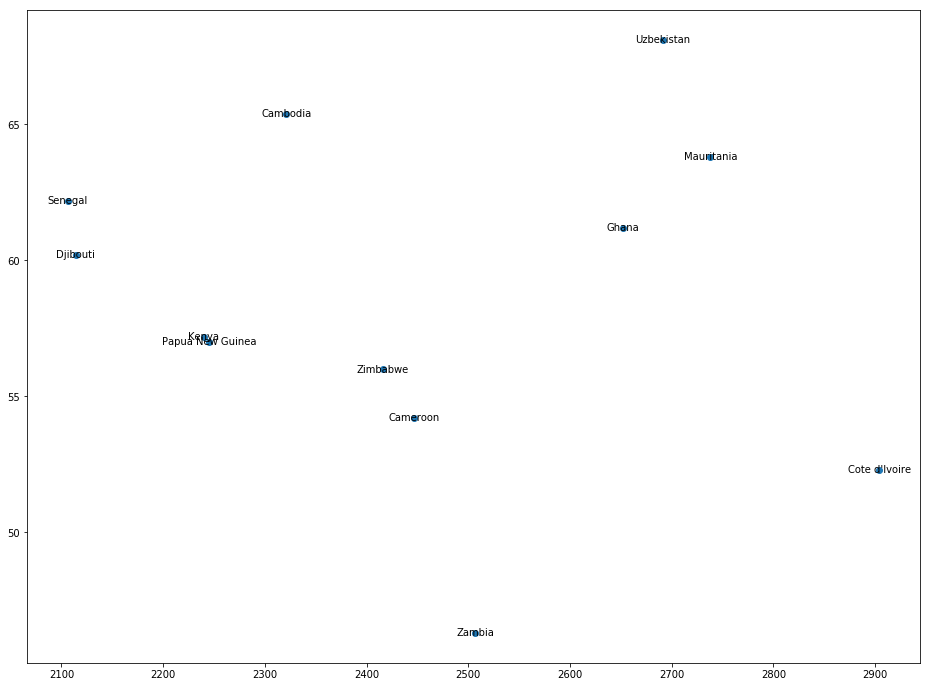

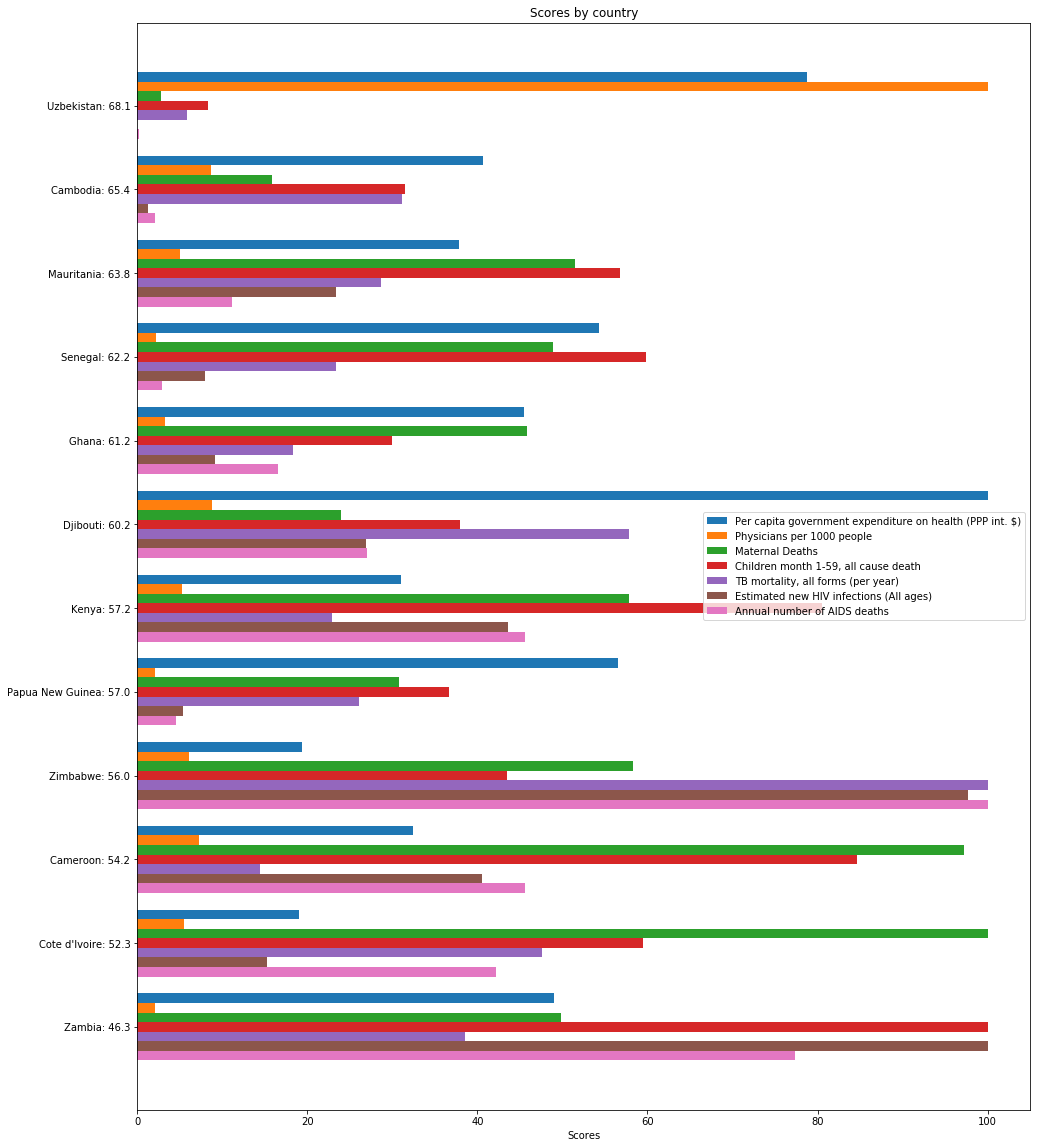

Per capita government expenditure on health (PPP int. $)    110.993599
Physicians per 1000 people                                    2.617000
Maternal Deaths                                              30.840094
Children month 1-59, all cause death                        488.289120
TB mortality, all forms (per year)                          302.512955
Estimated new HIV infections (All ages)                     648.152531
Annual number of AIDS deaths                                496.442051
dtype: float64

In [52]:
filter = (mr_all_indicators['GDP per capita'] > 2000) & (mr_all_indicators['GDP per capita'] < 3000)
dff = mr_all_indicators[filter].reset_index(drop=True).sort_values(x_name, ascending=True).reset_index(drop=True)

fig = plt.figure(figsize=(16,12))
ax = fig.add_subplot(1, 1, 1)
#ax.set_xscale('log')
bubble_plot(ax,dff,x_name = x_n)

fig = plt.figure(figsize=(16,20))
ax = fig.add_subplot(1, 1, 1)
#ax.set_xscale('log')
secondary_plot_grouped_by_year(ax,dff,loi)
dff[loi].max()

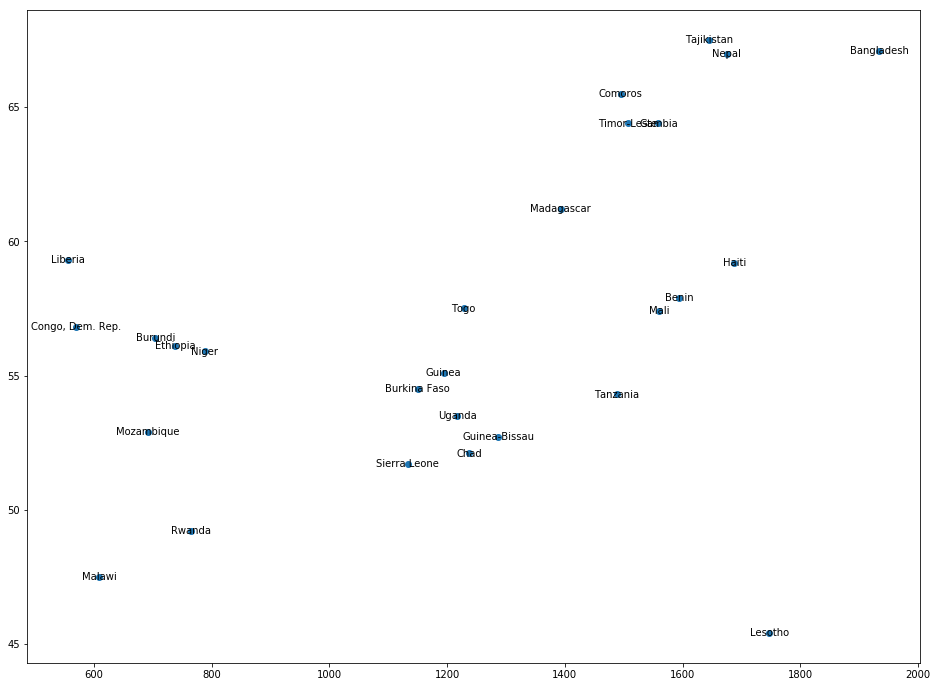

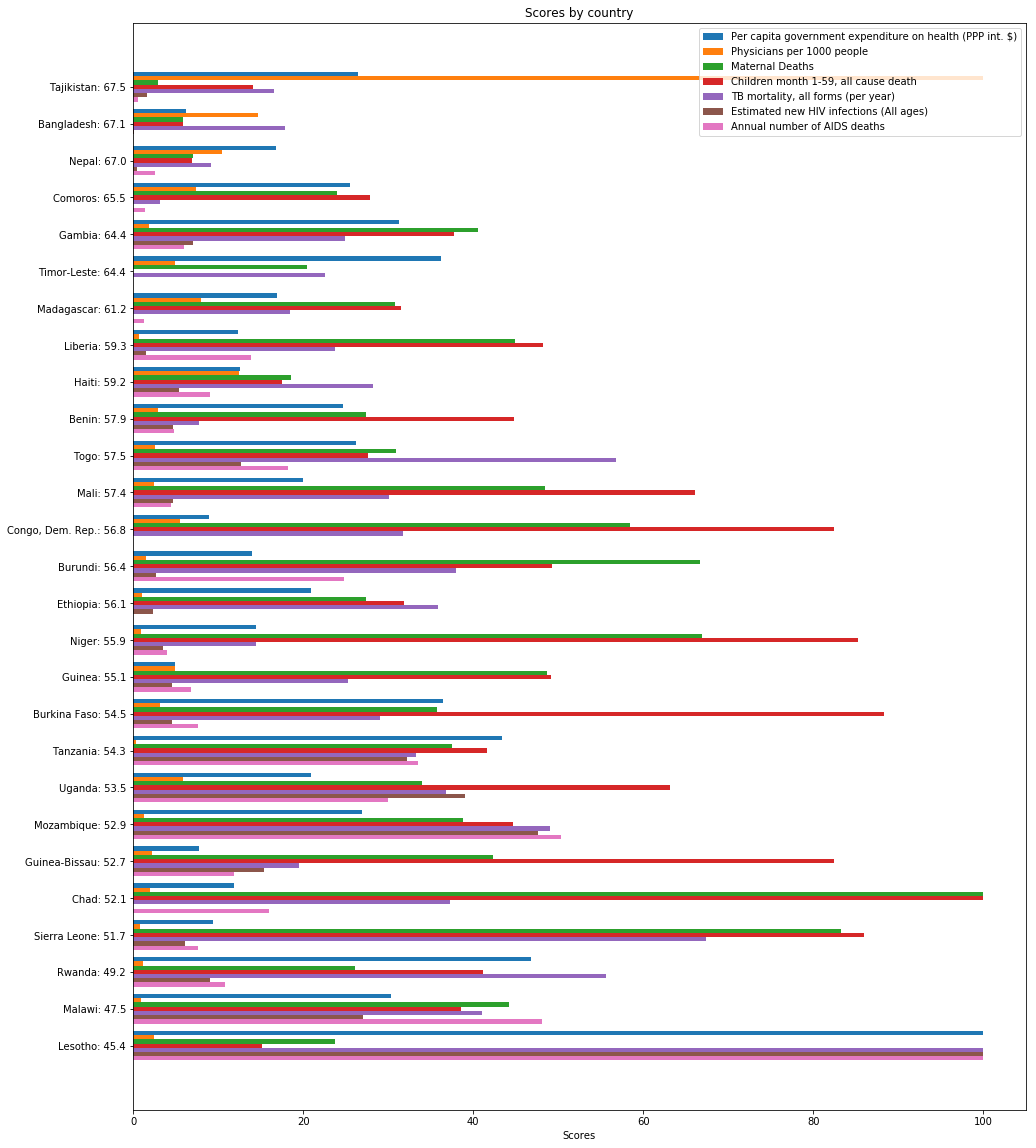

Per capita government expenditure on health (PPP int. $)     129.591907
Physicians per 1000 people                                     2.012800
Maternal Deaths                                               62.008768
Children month 1-59, all cause death                         818.301909
TB mortality, all forms (per year)                           278.178913
Estimated new HIV infections (All ages)                     1369.301730
Annual number of AIDS deaths                                 737.316316
dtype: float64

In [53]:
filter = (mr_all_indicators['GDP per capita'] > 0) & (mr_all_indicators['GDP per capita'] < 2000)
dff = mr_all_indicators[filter].reset_index(drop=True).sort_values(x_name, ascending=True).reset_index(drop=True)

fig = plt.figure(figsize=(16,12))
ax = fig.add_subplot(1, 1, 1)
#ax.set_xscale('log')
bubble_plot(ax,dff,x_name = x_n)

fig = plt.figure(figsize=(16,20))
ax = fig.add_subplot(1, 1, 1)
#ax.set_xscale('log')
secondary_plot_grouped_by_year(ax,dff,loi)
dff[loi].max()

# What do have countries with a high life expectancy in common?
Regardless of GDP

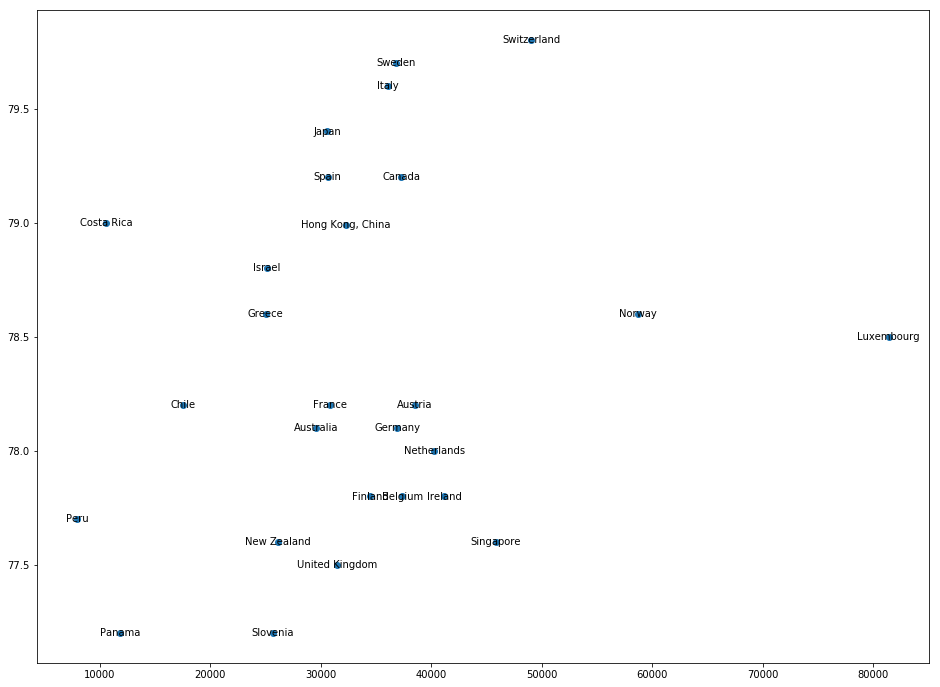

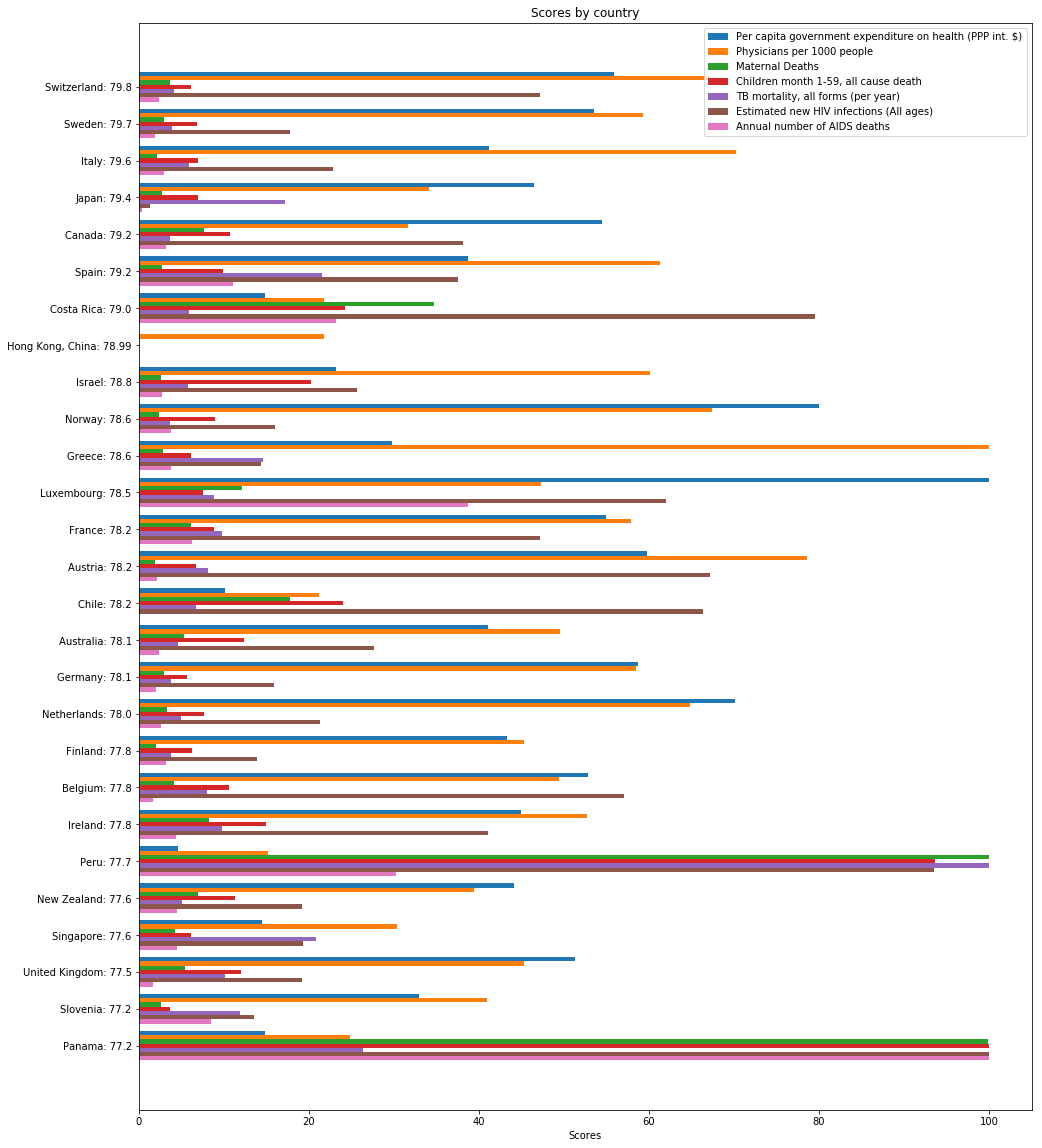

Per capita government expenditure on health (PPP int. $)    5691.672711
Physicians per 1000 people                                     6.043000
Maternal Deaths                                                1.896246
Children month 1-59, all cause death                          27.200616
TB mortality, all forms (per year)                            15.627930
Estimated new HIV infections (All ages)                       22.198544
Annual number of AIDS deaths                                  35.517670
dtype: float64

In [50]:
filter = (mr_all_indicators['Life expectancy'] > 77)
dff = mr_all_indicators[filter].reset_index(drop=True).sort_values(x_name, ascending=True).reset_index(drop=True)

fig = plt.figure(figsize=(16,12))
ax = fig.add_subplot(1, 1, 1)
#ax.set_xscale('log')
bubble_plot(ax,dff,x_name = x_n)

fig = plt.figure(figsize=(16,20))
ax = fig.add_subplot(1, 1, 1)
#ax.set_xscale('log')
secondary_plot_grouped_by_year(ax,dff,loi)
dff[loi].max()

In [38]:
s = pd.Series([0, 1, np.nan, 5, np.nan])
s.interpolate()

0    0.0
1    1.0
2    3.0
3    5.0
4    5.0
dtype: float64

In [39]:
from cycler import cycler
import itertools
from collections import OrderedDict
from functools import partial

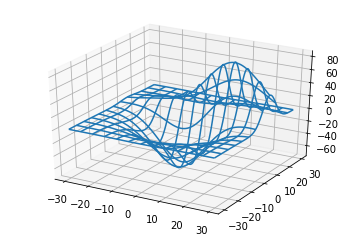

In [9]:
from mpl_toolkits.mplot3d import axes3d
import matplotlib.pyplot as plt


fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Grab some test data.
X, Y, Z = axes3d.get_test_data(0.05)

# Plot a basic wireframe.
ax.plot_wireframe(X, Y, Z, rstride=10, cstride=10)

plt.show()

In [1]:
import sqlite3

> **Tip**: Welcome to the Investigate a Dataset project! You will find tips in quoted sections like this to help organize your approach to your investigation. Before submitting your project, it will be a good idea to go back through your report and remove these sections to make the presentation of your work as tidy as possible. First things first, you might want to double-click this Markdown cell and change the title so that it reflects your dataset and investigation.

# Project: Investigate a Dataset (Replace this with something more specific!)

## Table of Contents
<ul>
<li><a href="#intro">Introduction</a></li>
<li><a href="#wrangling">Data Wrangling</a></li>
<li><a href="#eda">Exploratory Data Analysis</a></li>
<li><a href="#conclusions">Conclusions</a></li>
</ul>

<a id='intro'></a>
## Introduction

> **Tip**: In this section of the report, provide a brief introduction to the dataset you've selected for analysis. At the end of this section, describe the questions that you plan on exploring over the course of the report. Try to build your report around the analysis of at least one dependent variable and three independent variables.
>
> If you haven't yet selected and downloaded your data, make sure you do that first before coming back here. If you're not sure what questions to ask right now, then make sure you familiarize yourself with the variables and the dataset context for ideas of what to explore.

In [ ]:
# Use this cell to set up import statements for all of the packages that you
#   plan to use.

# Remember to include a 'magic word' so that your visualizations are plotted
#   inline with the notebook. See this page for more:
#   http://ipython.readthedocs.io/en/stable/interactive/magics.html


<a id='wrangling'></a>
## Data Wrangling

> **Tip**: In this section of the report, you will load in the data, check for cleanliness, and then trim and clean your dataset for analysis. Make sure that you document your steps carefully and justify your cleaning decisions.

### General Properties

In [ ]:
# Load your data and print out a few lines. Perform operations to inspect data
#   types and look for instances of missing or possibly errant data.


> **Tip**: You should _not_ perform too many operations in each cell. Create cells freely to explore your data. One option that you can take with this project is to do a lot of explorations in an initial notebook. These don't have to be organized, but make sure you use enough comments to understand the purpose of each code cell. Then, after you're done with your analysis, create a duplicate notebook where you will trim the excess and organize your steps so that you have a flowing, cohesive report.

> **Tip**: Make sure that you keep your reader informed on the steps that you are taking in your investigation. Follow every code cell, or every set of related code cells, with a markdown cell to describe to the reader what was found in the preceding cell(s). Try to make it so that the reader can then understand what they will be seeing in the following cell(s).

### Data Cleaning (Replace this with more specific notes!)

In [ ]:
# After discussing the structure of the data and any problems that need to be
#   cleaned, perform those cleaning steps in the second part of this section.


<a id='eda'></a>
## Exploratory Data Analysis

> **Tip**: Now that you've trimmed and cleaned your data, you're ready to move on to exploration. Compute statistics and create visualizations with the goal of addressing the research questions that you posed in the Introduction section. It is recommended that you be systematic with your approach. Look at one variable at a time, and then follow it up by looking at relationships between variables.

### Research Question 1 (Replace this header name!)

In [ ]:
# Use this, and more code cells, to explore your data. Don't forget to add
#   Markdown cells to document your observations and findings.


### Research Question 2  (Replace this header name!)

In [ ]:
# Continue to explore the data to address your additional research
#   questions. Add more headers as needed if you have more questions to
#   investigate.


<a id='conclusions'></a>
## Conclusions

> **Tip**: Finally, summarize your findings and the results that have been performed. Make sure that you are clear with regards to the limitations of your exploration. If you haven't done any statistical tests, do not imply any statistical conclusions. And make sure you avoid implying causation from correlation!

> **Tip**: Once you are satisfied with your work, you should save a copy of the report in HTML or PDF form via the **File** > **Download as** submenu. Before exporting your report, check over it to make sure that the flow of the report is complete. You should probably remove all of the "Tip" quotes like this one so that the presentation is as tidy as possible. Congratulations!